# Analysis of human and model behavior across physical domains

**The purpose of this notebook is to:** 
* Apply preprocessing to human behavioral data
* Visualize distribution and compute summary statistics over **human** physical judgments
* Visualize distribution and compute summary statistics over **model** physical judgments
* Conduct human-model comparisons
* Output CSV that can be re-loaded into R notebook for statistical modeling & fancy visualizations

**This notebook depends on:**
* Running `./generate_dataframes.py` (INTERNAL USE ONLY)
* Running `./upload_results.py` (INTERNAL USE ONLY)
* Running `./download_results.py` (PUBLIC USE)

In [2]:
#this is a sanity check to make sure that we're not missing stimuli
#keep running this after each cell to see where we went wrong
human_dom_stims = set(HD[HD['scenarioName'] == "dominoes"]['stim_ID'])
print("Got {} human stims".format(len(human_dom_stims)))
GNS_dom_stims = set(MD[(MD['Readout Test Data'] == 'dominoes') & (
    MD['Model Kind'] == 'GNS_nan_nan_nan_nan_L2 on particle 3D positions_1_same')]['Canon Stimulus Name'])
print("Got {} GNS stims".format(len(GNS_dom_stims)))
print("{} stims in common".format(
    len(human_dom_stims.intersection(GNS_dom_stims))))


NameError: name 'HD' is not defined

## setup

#### Load packages

In [3]:
import os
import sys
import urllib, io

sys.path.append('./analysis_helpers')
from importlib import reload

import numpy as np
import scipy.stats as stats
import pandas as pd

import analysis_helpers as h

import pymongo as pm
from collections import Counter
import json
import re
import ast

from PIL import Image, ImageOps, ImageDraw, ImageFont 

from io import BytesIO
import base64

from tqdm.notebook import tqdm

import  matplotlib
from matplotlib import pylab, mlab, pyplot
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
plt.style.use('seaborn-white')

import seaborn as sns

%matplotlib inline
import scipy.stats
import sklearn.metrics
import random

from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

#### options

In [4]:
# display all columns
pd.set_option('display.max_columns', None)

# seaborn plotting themes
sns.set_context('talk')
sns.set_style("whitegrid")

#### set up paths and directories

In [5]:
## directory & file hierarchy
proj_dir = os.path.abspath('..')
datavol_dir = os.path.join(proj_dir,'data')
analysis_dir =  os.path.abspath('.')
results_dir = os.path.join(proj_dir,'results')
plot_dir = os.path.join(results_dir,'plots')
csv_dir = os.path.join(results_dir,'csv')
json_dir = os.path.join(results_dir,'json')
exp_dir = os.path.abspath(os.path.join(proj_dir,'behavioral_experiments'))
png_dir = os.path.abspath(os.path.join(datavol_dir,'png'))

## add helpers to python path
if os.path.join(proj_dir,'stimuli') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'stimuli'))
    
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)   
    
if not os.path.exists(csv_dir):
    os.makedirs(csv_dir)       
    
## add helpers to python path
if os.path.join(analysis_dir,'utils') not in sys.path:
    sys.path.append(os.path.join(analysis_dir,'utils'))   

def make_dir_if_not_exists(dir_name):   
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)
    return dir_name

## create directories that don't already exist        
result = [make_dir_if_not_exists(x) for x in [results_dir,plot_dir,csv_dir]]

### load human data

In [6]:
from experiment_meta import *
HEM = pd.DataFrame(NEURIPS2021_EXPS) # HEM = "human experiment metadata"
HEM

,study,bucket_name,stim_version,iterationName
0,dominoes_pilot,human-physics-benchmarking-dominoes-pilot,production_1,production_1_testing
1,collision_pilot,human-physics-benchmarking-collision-pilot,production_2,production_2_testing
2,towers_pilot,human-physics-benchmarking-towers-pilot,production_2,production_2_testing
3,linking_pilot,human-physics-benchmarking-linking-pilot,production_2,production_2_testing
4,containment_pilot,human-physics-benchmarking-containment-pilot,production_2,production_2_testing
5,rollingsliding_pilot,human-physics-benchmarking-rollingsliding-pilot,production_2,production_2_testing
6,drop_pilot,human-physics-benchmarking-drop-pilot,production_2,production_2_testing
7,clothiness_pilot,human-physics-benchmarking-clothiness-pilot,production_2,production_2_testing


In [7]:
SCENARIOS = sorted([n.split("_")[0] for n in HEM['study'].unique()])

In [8]:
## get paths to all human response data
data_paths = [os.path.join(csv_dir,'humans',i) for i in os.listdir(os.path.join(csv_dir,'humans'))]
resp_paths = [i for i in data_paths if i.split('/')[-1].split('-')[0]=='human_responses']
assert len(resp_paths)==8

In [9]:
## tally up all flagged sessions


In [10]:
## also load all human data into a big dataframe
HD = pd.concat([h.apply_exclusion_criteria(h.load_and_preprocess_data(p), verbose=True) for p in resp_paths])
print("Loaded {} lines".format(len(HD)))

97.5th percentile for streak length is 12.0.
There are 3 flagged IDs so far due to long streaks.
There are 0 flagged IDs so far due to alternating sequences.
TODO: Still need to flag familiarization trial failures!!!!
There are 2 flagged IDs so far due to low accuracy.
There are 1 flagged IDs so far due to high RTs.
There are a total of 6 flagged IDs.
There are a total of 94 valid and complete sessions for collision.
97.5th percentile for streak length is 12.0.
There are 4 flagged IDs so far due to long streaks.
There are 0 flagged IDs so far due to alternating sequences.
TODO: Still need to flag familiarization trial failures!!!!
There are 3 flagged IDs so far due to low accuracy.
There are 0 flagged IDs so far due to high RTs.
There are a total of 4 flagged IDs.
There are a total of 96 valid and complete sessions for rollingsliding.
97.5th percentile for streak length is 12.0.
There are 12 flagged IDs so far due to long streaks.
There are 0 flagged IDs so far due to alternating seque

#### exclude subjects from familiarization
Run `familiariarization_exclusion.ipynb` to generate `excluded_games.csv`

In [11]:
bad_games = pd.read_csv(os.path.join(csv_dir,"humans/excluded_games.csv")).values[:,1]

In [12]:
bad_games

array(['0720-d5f527dc-d86a-4d88-af8f-b70ac9264fef',
       '1685-8963fea0-0d21-454b-8bbe-e9cbc792aa11',
       '4917-538725a5-383f-462b-9ab7-43b9473c9dcc',
       '7411-987b0a97-8a67-41a3-a3d8-d8f792c35ab5',
       '8383-e0582a4e-6498-4d91-bb29-2b6a363cc2e9',
       '8731-67e86658-28ff-4cc6-b722-9620e3b3ce43',
       '9784-7a67e88b-0416-4b55-8a72-9a0d99038c49',
       '9808-e983d3b8-75c3-428a-8182-f57fd645abb1',
       '9930-aa52e4be-e5e3-441a-9cb4-f1144d9e233f'], dtype=object)

In [13]:
print("Excluding {} rows for {} games".format(sum(HD['gameID'].isin(bad_games)), len(bad_games)))
HD = HD[~HD['gameID'].isin(bad_games)]

Excluding 900 rows for 9 games


### load model data

In [14]:
## get paths to all model data
model_data_paths = [os.path.join(csv_dir,'models',i) for i in os.listdir(os.path.join(csv_dir,'models'))]
model_res_paths = [i for i in model_data_paths if i.split('.')[-1] == "csv"]

In [15]:
## load all model results into a single dataframe
MD = pd.concat([pd.read_csv(p).assign(filename=p.split('/')[-1]) for p in model_res_paths])
print("Loaded {} rows".format(len(MD)))

Loaded 248011 rows


In [16]:
# a couple of import steps (restore original scenario names, add single prediction value, add correctness column)
MD = h.process_model_dataframe(MD)

In [17]:
#check for duplicated rows
if len(MD.duplicated()) > 0:
    print("⚠️There are {} duplicated rows!".format(np.sum(MD.duplicated())))
    MD = MD[~MD.duplicated(h.MODEL_COLS+["Stimulus Name"],keep="first")]
    print("Removed duplicates, {} rows left".format(len(MD)))

⚠️There are 0 duplicated rows!
Removed duplicates, 248011 rows left


In [18]:
# save model kinds to variable
MODELS = list(MD["Model Kind"].unique())

In [19]:
print("We get the following kinds of models:")
display(MODELS)

We get the following kinds of models:


['VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_same',
 'RPIN_R-CNN_0.0_L2 on 2D position_all_but_this_L2 on 2D position_0_same',
 'RPIN_R-CNN_0.0_L2 on 2D position_all_L2 on 2D position_0_same',
 'RPIN_R-CNN_0.0_L2 on 2D position_same_L2 on 2D position_0_same',
 'RPIN_R-CNN_1.0_L2 on 2D position_all_but_this_L2 on 2D position_1_same',
 'RPIN_R-CNN_2.0_L2 on 2D position_all_but_this_L2 on 2D position_2_same',
 'RPIN_R-CNN_1.0_L2 on 2D position_all_L2 on 2D position_1_same',
 'RPIN_R-CNN_2.0_L2 on 2D position_all_L2 on 2D position_2_same',
 'RPIN_R-CNN_1.0_L2 on 2D position_same_L2 on 2D position_1_same',
 'RPIN_R-CNN_2.0_L2 on 2D position_same_L2 on 2D position_2_same',
 'SVG_VGG_1.0_VAE_all_but_this_VAE_1_same',
 'SVG_VGG_1.0_VAE_all_VAE_1_same',
 'SVG_VGG_1.0_VAE_same_VAE_1_same',
 'VGGFrozenLSTM_VGG_nan_nan_nan_L2 on latent_0_same',
 'SVG_VGG_2.0_VAE_all_but_this_VAE_2_same',
 'SVG_VGG_0.0_VAE_all_but_this_VAE_0_same',
 'SVG_VGG_2.0_VAE_all_VAE_2_same',
 'SVG_VGG_0.0_VAE_all_VAE_0_sam

#### exclude bad stims (where model/human stims mismatched)

In [20]:
stim_comparision = pd.merge(pd.DataFrame(MD.groupby('Canon Stimulus Name')['Actual Outcome'].first()).reset_index(),pd.DataFrame(HD.groupby('stim_ID')['target_hit_zone_label'].first()).reset_index(),left_on='Canon Stimulus Name',right_on='stim_ID')

bad_stims = stim_comparision[stim_comparision['Actual Outcome'] != stim_comparision['target_hit_zone_label']]['Canon Stimulus Name']
print("There are {} bad stims".format(len(bad_stims)))

There are 37 bad stims


In [21]:
#Exclude bad stims
HD = HD[~HD['stim_ID'].isin(bad_stims)]
MD = MD[~MD['Canon Stimulus Name'].isin(bad_stims)]

In [22]:
#Also exclude stims from the rollingsliding ledge subset
HD = HD[~HD['stim_ID'].str.contains("rollingSliding_simple_ledge")]
MD = MD[~MD['Canon Stimulus Name'].str.contains("rollingSliding_simple_ledge")]

### generate labels for regression analysis
* Comparison 1: Visual encoder architecture (ConvNet [SVG/VGGFrozenLSTM] vs. transformer [DEITFrozenLSTM] … DEITFrozenMLP vs. SVG/VGGFrozenMLP)
* Comparison 2: Dynamics model RNN vs. MLP (LSTM vs. MLP for above)
* Comparison 3: Among unsupervised models, object-centric vs. non-object-centric
        * {CSWM, OP3} vs. {SVG}
* Comparison 4: Latent vs. pixel reconstruction loss
        * CSWM vs. OP3
* Comparison 5: RPIN vs. CSWM/OP3 (“supervised explicit object-centric” vs. “unsupervised implicit object-centric”)

Dimensions: 
* “Visual encoder architecture” : [“ConvNet” “Transformer” “Neither”]
* “Dynamics model architecture” : [“LSTM”, “MLP”, “Neither”]
* “ObjectCentric”: [TRUE, FALSE, NA]
* “Supervised”: [TRUE, FALSE]
* “SelfSupervisedLoss”: [“latent”, “pixel”, “NA”]


In [23]:
#“Visual encoder architecture” : [“ConvNet” “Transformer” “Neither”]
MD['Visual encoder architecture'] = "Neither"
MD.loc[(MD['Model'].str.contains("SVG")) | (MD['Model'].str.contains("VGG")),'Visual encoder architecture'] = "ConvNet"
MD.loc[(MD['Model'].str.contains("DEIT")) | (MD['Model'].str.contains("VGG")),'Visual encoder architecture'] = "Transformer"

In [24]:
# “Dynamics model architecture” : [“LSTM”, “MLP”, “Neither”]
MD['Dynamics model architecture'] = "Neither"
MD.loc[(MD['Model'].str.contains("LSTM")),'Dynamics model architecture'] = "LSTM"
MD.loc[(MD['Model'].str.contains("MLP")),'Dynamics model architecture'] = "MLP"

In [25]:
# ObjectCentric”: [TRUE, FALSE, NA]
MD['ObjectCentric'] = np.nan
MD.loc[(MD['Model'].str.contains("CSWM")) | (MD['Model'].str.contains("OP3")) | (MD['Model'].str.contains("DPI")),'ObjectCentric'] = True
MD.loc[(MD['Model'].str.contains("SVG")),'ObjectCentric'] = False
# MD['ObjectCentric'] = MD['ObjectCentric'].astype(bool)

In [26]:
# Supervised”: [TRUE, FALSE]
MD['Supervised'] = np.nan
MD.loc[(MD['Model'].str.contains("RPIN")) | (MD['Model'].str.contains("DPI")),'Supervised'] = True
MD.loc[(MD['Model'].str.contains("CSWM")) | (MD['Model'].str.contains("OP3")) | (MD['Model'].str.contains("SVG") | (MD['Model'].str.contains("VGG"))),'Supervised'] = False
# MD['Supervised'] = MD['Supervised'].astype(bool)

In [27]:
# SelfSupervisedLoss”: [“latent”, “pixel”, “NA”]
MD['SelfSupervisedLossSelfSupervisedLoss'] = "NA"
MD.loc[(MD['Model'].str.contains("CSWM")),'SelfSupervisedLoss'] = "latent"
MD.loc[(MD['Model'].str.contains("OP3")) | (MD['Model'].str.contains("VGG")) | (MD['Model'].str.contains("SVG") | (MD['Model'].str.contains("VGG"))),'SelfSupervisedLoss'] = "pixel"

In [28]:
#save as model identifying column
MODEL_COLS = h.MODEL_COLS + ['Visual encoder architecture','Dynamics model architecture','ObjectCentric','Supervised','SelfSupervisedLossSelfSupervisedLoss']

In [29]:
## save out 
MD.to_csv(os.path.join(csv_dir, 'summary', 'allModels_results.csv'))

### generate summary table of human 95% CIs for accuracy across all scenarios

In [30]:
## init human_bootstrapped_accuracy for plotting
human_bootstrapped_accuracy = pd.DataFrame()

for exp_ind, exp_name in enumerate(resp_paths):
    
    ## get path to response data
    path_to_data = resp_paths[exp_ind]

    ## load data and apply preprocessing
    _D = h.load_and_preprocess_data(path_to_data)
    scenarioName = _D.scenarioName.values[0]
    print('Currently analyzing the {} experiment.'.format(_D.scenarioName.values[0]))
    clear_output(wait=True)
    
    ## apply exclusion criteria
    D = h.apply_exclusion_criteria(_D)
    D = D[~D['gameID'].isin(bad_games)]
    
    D = D.sort_values('stim_ID') #ensure same stim order
    humans = np.array(D['gameID'].unique())

    ## compute bootstrapped sampling distributions of accuracy
    Dacc = D.groupby('prolificIDAnon').agg({'correct':np.mean})
    bootmeans = h.bootstrap_mean(Dacc, col='correct', nIter=1000)

    obsmean = np.mean(Dacc.correct.values)
    bootmean = np.mean(bootmeans)
    lb = np.percentile(bootmeans,2.5)
    ub = np.percentile(bootmeans,97.5)
    pct25 = np.percentile(Dacc,2.5)
    pct975 = np.percentile(Dacc,97.5)
    ## merge bootstrapped accuracy estimates
    if len(human_bootstrapped_accuracy)==0:
        human_bootstrapped_accuracy = pd.DataFrame(['human', scenarioName, obsmean,bootmean,lb,ub, pct25, pct975]).transpose()
    else:
        human_bootstrapped_accuracy = pd.concat([human_bootstrapped_accuracy, pd.DataFrame(['human', scenarioName, obsmean,bootmean,lb,ub, pct25, pct975]).transpose()],axis=0)
        
## add column names        
human_bootstrapped_accuracy.columns=['agent','scenario','obs_mean', 'boot_mean', 'ci_lb', 'ci_ub', 'pct_2.5', 'pct_97.5']

## save out human_bootstrapped_accuracy to re-plot in R
if not os.path.exists(os.path.join(csv_dir, 'summary')):
    os.makedirs(os.path.join(csv_dir, 'summary'))    
human_bootstrapped_accuracy.to_csv(os.path.join(csv_dir, 'summary','human_accuracy_by_scenario.csv'), index=False)
print('Saved to file! Done.')

Saved to file! Done.


In [31]:
human_bootstrapped_accuracy

,agent,scenario,obs_mean,boot_mean,ci_lb,ci_ub,pct_2.5,pct_97.5
0,human,collision,0.808511,0.808485,0.798793,0.81766,0.704333,0.88
0,human,rollingsliding,0.884421,0.884619,0.877333,0.891516,0.795667,0.94
0,human,dominoes,0.694206,0.694126,0.685395,0.702306,0.62,0.76
0,human,drop,0.743656,0.743722,0.73541,0.751326,0.666667,0.804667
0,human,clothiness,0.677207,0.677505,0.663601,0.691804,0.543167,0.7725
0,human,linking,0.643488,0.643601,0.631312,0.655271,0.535833,0.745
0,human,containment,0.766988,0.766892,0.758072,0.775026,0.686667,0.839667
0,human,towers,0.763137,0.763012,0.754975,0.770982,0.669333,0.826


### Human-human consistency across stimuli (within scenario)
We will analyze human-human consistency by computing the mean correlation between (binary) response vectors produced by each human participant across all stimuli within each scenario. 

#### Correlation

In [32]:
## init human_boot_corr for plotting
human_boot_corr = pd.DataFrame()

for exp_ind, exp_name in enumerate(resp_paths):
    
    ## get path to response data
    path_to_data = resp_paths[exp_ind]

    ## load data and apply preprocessing
    _D = h.load_and_preprocess_data(path_to_data)
    scenarioName = _D.scenarioName.values[0]
    print('Currently analyzing the {} experiment.'.format(_D.scenarioName.values[0]))
    clear_output(wait=True)

    ## apply exclusion criteria
    D = h.apply_exclusion_criteria(_D)
    D = D[~D['gameID'].isin(bad_games)]
    
    ## create response feature matrix (numSubs x numTrialsPerSub)
    D2 = D.sort_values(by=['prolificIDAnon','stim_ID']).reset_index(drop=True)
    numSubs = len(np.unique(D['prolificIDAnon'].values))
    numTrialsPerSub = int(len(D)/numSubs)
    respMat = np.reshape(D2['responseBool'].values, (numSubs,numTrialsPerSub)) 

    ## sanity check that the reshape operation happened correctly
    assert len([i for (i,j) in list(zip(respMat[0],D2[:150]['responseBool'].values)) if i!=j])==0    
    
    ## get pairwise correlations
    dists = 1-scipy.spatial.distance.pdist(respMat, metric='correlation')
    corrMat = scipy.spatial.distance.squareform(dists)
    
    ## get percentiles over pairwise corrs
    pairwiseCorrs = corrMat[np.triu_indices(n=len(corrMat), k=1)]
    lb = np.percentile(pairwiseCorrs, 2.5)
    med = np.percentile(pairwiseCorrs, 50)
    ub = np.percentile(pairwiseCorrs, 97.5)  
    
    ## get pearsons r by splitting the subject pool in half and comparing mean responses
    humans = np.array(D['gameID'].unique())
    pearsons_rs = []
    for i in range(1000):
        # shuffle human indices
        shuffled_humans = humans.copy()
        np.random.shuffle(shuffled_humans)
        # get group A
        humans_A = shuffled_humans[:int(len(shuffled_humans)/2)]
        mask_A = D['gameID'].isin(humans_A)
        #get responses for the two groups
        resp_A = D[mask_A].groupby('stim_ID')['responseBool'].mean()
        resp_B = D[~mask_A].groupby('stim_ID')['responseBool'].mean()
        assert np.all(resp_A.index == resp_B.index)
        # calc r
        r,_ = scipy.stats.pearsonr(resp_A.values, resp_B.values)
        pearsons_rs.append(r)
    # get mean and intervals
    r_mean = np.mean(pearsons_rs)
    r_lb = np.percentile(pearsons_rs,2.5)
    r_ub = np.percentile(pearsons_rs,97.5)
    r_med = np.percentile(pearsons_rs,50)
        
    if len(human_boot_corr)==0:
        human_boot_corr = pd.DataFrame(['human', scenarioName, lb, med, ub, r_mean, r_lb, r_ub, r_med]).transpose()
    else:
        human_boot_corr = pd.concat([human_boot_corr, pd.DataFrame(['human', scenarioName, lb, med, ub, r_mean, r_lb, r_ub, r_med]).transpose()],axis=0)
        
## add column names        
human_boot_corr.columns=['agent','scenario','corr_lb', 'corr_med', 'corr_ub', 'r_mean', 'r_lb', 'r_ub', 'r_med']

## save out human_boot_corr to re-plot in R
if not os.path.exists(os.path.join(csv_dir, 'summary')):
    os.makedirs(os.path.join(csv_dir, 'summary'))    
human_boot_corr.to_csv(os.path.join(csv_dir, 'summary','human_pairwiseCorrs_by_scenario.csv'), index=False)
print('Saved to file! Done.')

Saved to file! Done.


In [33]:
human_boot_corr

,agent,scenario,corr_lb,corr_med,corr_ub,r_mean,r_lb,r_ub,r_med
0,human,collision,0.388046,0.62822,0.776057,0.987027,0.981731,0.990954,0.987302
0,human,rollingsliding,0.521549,0.7174,0.852066,0.991466,0.988116,0.994019,0.991652
0,human,dominoes,0.231102,0.425554,0.591273,0.96868,0.959311,0.976166,0.968927
0,human,drop,0.266334,0.501544,0.681139,0.978659,0.971667,0.984138,0.978972
0,human,clothiness,0.057995,0.352121,0.555425,0.944892,0.923362,0.959081,0.945959
0,human,linking,0.112735,0.389653,0.571606,0.963857,0.950729,0.973763,0.964243
0,human,containment,0.306122,0.559038,0.725013,0.980927,0.974032,0.985924,0.981242
0,human,towers,0.299731,0.565581,0.725722,0.982063,0.975504,0.987046,0.982378


#### Cohen's $\kappa$

In [34]:
## init human_boot_cohenk for plotting
human_boot_cohenk = pd.DataFrame()

for exp_ind, exp_name in enumerate(resp_paths):
    
    ## get path to response data
    path_to_data = resp_paths[exp_ind]

    ## load data and apply preprocessing
    _D = h.load_and_preprocess_data(path_to_data)
    scenarioName = _D.scenarioName.values[0]
    print('Currently analyzing the {} experiment.'.format(_D.scenarioName.values[0]))
    clear_output(wait=True)

    ## apply exclusion criteria
    D = h.apply_exclusion_criteria(_D)
    D = D[~D['gameID'].isin(bad_games)]
    
    ## create response feature matrix (numSubs x numTrialsPerSub)
    D2 = D.sort_values(by=['prolificIDAnon','stim_ID']).reset_index(drop=True)
    numSubs = len(np.unique(D['prolificIDAnon'].values))
    numTrialsPerSub = int(len(D)/numSubs)
    respMat = np.reshape(D2['responseBool'].values, (numSubs,numTrialsPerSub)) 

    ## sanity check that the reshape operation happened correctly
    assert len([i for (i,j) in list(zip(respMat[0],D2[:150]['responseBool'].values)) if i!=j])==0    
      
    ## compute Cohen's kappa
    ## with a horrific double loop
    kappas = []
    for i in range(respMat.shape[0]): # for each participant
        for j in range(i+1,respMat.shape[0]): # compare to every participant after them
            assert i != j
            kappa = sklearn.metrics.cohen_kappa_score(respMat[i],respMat[j])
            kappas.append(kappa)
    
    ## get percentiles over pairwise corrs
    lb = np.percentile(kappas, 2.5)
    med = np.percentile(kappas, 50)
    ub = np.percentile(kappas, 97.5)  
        
    if len(human_boot_cohenk)==0:
        human_boot_cohenk = pd.DataFrame(['human', scenarioName, lb, med, ub]).transpose()
    else:
        human_boot_cohenk = pd.concat([human_boot_cohenk, pd.DataFrame(['human', scenarioName, lb, med, ub]).transpose()],axis=0)
        
## add column names        
human_boot_cohenk.columns=['agent','scenario','corr_lb', 'corr_med', 'corr_ub']

## save out human_boot_cohenk to re-plot in R
if not os.path.exists(os.path.join(csv_dir, 'summary')):
    os.makedirs(os.path.join(csv_dir, 'summary'))    
human_boot_cohenk.to_csv(os.path.join(csv_dir, 'summary','human_pairwiseCohensKs_by_scenario.csv'), index=False)
print('Saved to file! Done.')

Saved to file! Done.


In [35]:
human_boot_cohenk

,agent,scenario,corr_lb,corr_med,corr_ub
0,human,collision,0.382824,0.619358,0.772932
0,human,rollingsliding,0.50824,0.707758,0.851335
0,human,dominoes,0.209206,0.410856,0.583971
0,human,drop,0.260437,0.494367,0.678875
0,human,clothiness,0.064171,0.340571,0.54401
0,human,linking,0.108576,0.37177,0.562288
0,human,containment,0.284806,0.546667,0.719987
0,human,towers,0.285117,0.549918,0.720673


## Visualize distribution of model physical judgments, by domain

## Compute summary statistics over model physical judgments, by domain

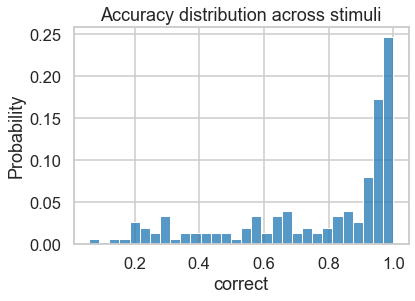

In [36]:
Dacc = D.groupby('stim_ID').agg({'correct':np.mean})
p = sns.histplot(data=Dacc, x='correct', bins=30, stat='probability')
t = plt.title('Accuracy distribution across stimuli')

## Conduct human-model comparisons
We will compare human and model behavior in two ways: **absolute performance** and **response pattern.**

#### **Absolute Performance** 
We will compare the accuracy of each model to the mean accuracy of humans, for each scenario. 
To do this, we will first compute estimates of mean human accuracy for each scenario and construct 95% confidence intervals for each of these estimates. 
These confidence intervals will be constructed by bootstrapping: specifically, for an experiment with N participants, we will resample N participants with replacement and compute the proportion correct for that bootstrapped sample. We will take repeat this resampling procedure 1000 times to generate a sampling distribution for the mean proportion correct. The 2.5th and 97.5th percentile will be extracted from this sampling distribution to provide the lower and upper bounds of the 95% confidence interval.

For each model, we will then compare their proportion correct (a point estimate) to the human confidence interval. 

In [37]:
# group model data by scenario
MD_by_scenario = MD.groupby(['Readout Test Data','ModelID']).agg(
        {**{ 'correct':'mean' },
         **{ col:'first' for col in MODEL_COLS+h.DATASET_ABSTRACTED_COLS} #save model identifying data as well
        })

In [38]:
accuracies = {}

for scenario in sorted(MD['Readout Test Data'].unique()):
    print("Now running scenario",scenario)
    _MD_by_scenario = MD_by_scenario.loc[[scenario]]
    for _,model_row in list(_MD_by_scenario.iterrows()):
        #each model is one row of MD
        human_row = human_bootstrapped_accuracy.query("scenario == @scenario")
#         assert len(model_row) == len(human_row) == 1
        correct_ratio = model_row['correct']/human_row['obs_mean']
        correct_diff = model_row['correct'] - human_row['obs_mean']
        accuracies[(scenario,model_row.name[1])] = {**{
                                                    'scenario': scenario,
                                                    'ratio': float(correct_ratio), 
                                                    'diff': float(correct_diff),
                                                    'human_correct': float(human_row['obs_mean']),
                                                    'model_correct': float(model_row['correct']),
                                                    },**{col: model_row[col] for col in MODEL_COLS+h.DATASET_ABSTRACTED_COLS}} # save information for model identification
    clear_output(wait=True)

model_human_accuracies = pd.DataFrame(accuracies).transpose()  
model_human_accuracies.to_csv(os.path.join(csv_dir, 'summary','model_human_accuracies.csv'), index=False)
print('Saved to file. Done!')

Saved to file. Done!


#### **Response Pattern**
We will compare the pattern of predictions generated by each model to the pattern of predictions generated by humans. 

We will do this by using two standard inter-rater reliability metrics:

##### **Correlation between average-human and model responses**
For each stimulus, we will compute the proportion of "hit" responses by humans. 
For each stimulus, we will extract the hit probability generated by models.
For each scenario (i.e., domain), we will compute the root-mean-squared-deviation between the human proportion-hit vector and the model probability-hit vector. 
To estimate variability across human samples, we will conduct bootstrap resampling (i.e., resampling data from individual participants with replacement), where for each bootstrap sample we will re-compute the correlation between the model probability-hit vector and the (bootstrapped) human proportion-hit vector.

##### **Correlation** (DEPRECATED, SUPERSEDED BY COHEN's KAPPA BELOW, WHICH CORRECTS FOR CHANCE AGREEMENT RATE)
For each pair of human participants, we will compute the correlation between their (binary) response vectors, yielding a distribution of pairwise human-human correlations. 
For each model, we will compute the correlation between its response vector and every human participant, as well as every other model. 
A model's response pattern will be considered more similar to humans' insofar as the mean model-human correlation (across humans) lies closer to the mean human-human correlation (for all pairs of humans).


#### Correlation

In [39]:
out_dict = {}


for scenario in sorted(MD['Readout Test Data'].unique()):
    print("Now running scenario",scenario)
    _MD = MD[MD['Readout Test Data'] == scenario]
    _HD = HD[HD['scenarioName'] == scenario].sort_values('stim_ID')
    for model in _MD['ModelID'].unique():
        #get responses of model        
        _MD_model = _MD[_MD['ModelID'] == model]
        _MD_model = _MD_model.sort_values('Canon Stimulus Name') #ensure same stim order 
        
        ## get average human response vector
        _HD_resp = _HD.groupby('stim_ID')['responseBool'].mean().reset_index()
        #in case the models have more or less responses compared to humans
        human_stim_names = set(list(_HD['stim_ID']))
        model_stim_names = set(list(_MD_model['Canon Stimulus Name']))
        joint_stim_names = human_stim_names.intersection(model_stim_names)
        if len(joint_stim_names) == 0:
            print("⛔️ {} is missing all datapoints on {} human responses".format(model, len(human_stim_names)),end="\r")
            continue #ignore and move on
        if len(human_stim_names) > len(joint_stim_names):
            print("⚠️ {} is missing {} datapoints on {} human responses".format(model,len(human_stim_names) - len(joint_stim_names), len(human_stim_names)),end="\r")

        #subset both models to ensure only common stims are used
        _MD_model = _MD_model[_MD_model['Canon Stimulus Name'].isin(joint_stim_names)]            
        _HD_resp = _HD_resp[_HD_resp['stim_ID'].isin(joint_stim_names)]           
        ## make sure order is exactly the same
        assert len([i for (i,j) in zip(_MD_model['Canon Stimulus Name'].values, _HD_resp['stim_ID'].values) if i!=j])==0
        
        ## extract human & model responses as arrays
        model_responses = _MD_model['Predicted Prob_true'].values
        human_responses = _HD_resp['responseBool'].values

        ## compute RMSE per stimulus
        RMSE = scipy.spatial.distance.euclidean(model_responses, human_responses) / len(model_responses)
        correlation,p = scipy.stats.pearsonr(model_responses, human_responses)
        
        out_dict[(scenario, model)] = {**{'scenario':scenario,
                                          'modelID': model,
                                          'RMSE':RMSE,
                                          'pearsons_r':correlation,
                                          'p_pearsons_r':p,
                                          'num_datapoints':len(model_responses)},
                                           **{col:_MD_model.head(1)[col].item() for col in MODEL_COLS+h.DATASET_ABSTRACTED_COLS} #save model ID info
                                      }
        clear_output(wait=True)        

model_human_rmse = pd.DataFrame(out_dict).transpose()  
model_human_rmse.columns = model_human_rmse.columns.get_level_values(0) ## flatten multi-level index
model_human_rmse.reset_index(drop=True) ## get rid of multi-level index
model_human_rmse = model_human_rmse.assign(RMSE = pd.to_numeric(model_human_rmse['RMSE']))
model_human_rmse.to_csv(os.path.join(csv_dir, 'summary','model_human_pearsonsr_rmse.csv'), index=False)
print('Saved to file. Done!')        

Saved to file. Done!


In [40]:
out_dict = {}


for scenario in sorted(MD['Readout Test Data'].unique()):
    print("Now running scenario",scenario)
    _MD = MD[MD['Readout Test Data'] == scenario]
    _HD = HD[HD['scenarioName'] == scenario].sort_values('stim_ID')
    for model in _MD['ModelID'].unique():
        #get responses of model        
        _MD_model = _MD[_MD['ModelID'] == model]
        _MD_model = _MD_model.sort_values('Canon Stimulus Name') #ensure same stim order 
        
        ## get average human response vector
        _HD_resp = _HD.groupby('stim_ID')['responseBool'].mean().reset_index()
        #in case the models have more or less responses compared to humans
        human_stim_names = set(list(_HD['stim_ID']))
        model_stim_names = set(list(_MD_model['Canon Stimulus Name']))
        joint_stim_names = human_stim_names.intersection(model_stim_names)
        if len(joint_stim_names) == 0:
            print("⛔️ {} is missing all datapoints on {} human responses".format(model, len(human_stim_names)),end="\r")
            continue #ignore and move on
        if len(human_stim_names) > len(joint_stim_names):
            print("⚠️ {} is missing {} datapoints on {} human responses".format(model,len(human_stim_names) - len(joint_stim_names), len(human_stim_names)),end="\r")

        #subset both models to ensure only common stims are used
        _MD_model = _MD_model[_MD_model['Canon Stimulus Name'].isin(joint_stim_names)]            
        _HD_resp = _HD_resp[_HD_resp['stim_ID'].isin(joint_stim_names)]           
        ## make sure order is exactly the same
        assert len([i for (i,j) in zip(_MD_model['Canon Stimulus Name'].values, _HD_resp['stim_ID'].values) if i!=j])==0
        
        ## extract human & model responses as arrays
        model_responses = _MD_model['Predicted Prob_true'].values
        human_responses = _HD_resp['responseBool'].values

        ## compute RMSE per stimulus
        RMSE = scipy.spatial.distance.euclidean(model_responses, human_responses) / len(model_responses)
        correlation,p = scipy.stats.pearsonr(model_responses, human_responses)
        
        out_dict[(scenario, model)] = {**{'scenario':scenario,
                                          'modelID': model,
                                          'RMSE':RMSE,
                                          'pearsons_r':correlation,
                                          'p_pearsons_r':p,
                                          'num_datapoints':len(model_responses)},
                                           **{col:_MD_model.head(1)[col].item() for col in MODEL_COLS+h.DATASET_ABSTRACTED_COLS} #save model ID info
                                      }
        clear_output(wait=True)        

model_human_rmse = pd.DataFrame(out_dict).transpose()  
model_human_rmse.columns = model_human_rmse.columns.get_level_values(0) ## flatten multi-level index
model_human_rmse.reset_index(drop=True) ## get rid of multi-level index
model_human_rmse = model_human_rmse.assign(RMSE = pd.to_numeric(model_human_rmse['RMSE']))
model_human_rmse.to_csv(os.path.join(csv_dir, 'summary','model_human_pearsonsr_rmse.csv'), index=False)
print('Saved to file. Done!')        

Saved to file. Done!


In [41]:
model_human_rmse

scenario  \
clothiness VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_all...  clothiness   
           VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_all...  clothiness   
           VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_all...  clothiness   
           VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_no_...  clothiness   
           VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_no_...  clothiness   
...                                                                   ...   
towers     GNS_nan_nan_nan_nan_L2 on particle 3D positions...      towers   
           GNS_nan_nan_nan_nan_L2 on particle 3D positions...      towers   
           DPI_nan_nan_nan_nan_L2 on particle 3D positions...      towers   
           DPI_nan_nan_nan_nan_L2 on particle 3D positions...      towers   
           DPI_nan_nan_nan_nan_L2 on particle 3D positions...      towers   

                                                                                                         modelID  \
clothiness VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_all...  VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_al...   
           VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_all...  VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_al...   
           VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_all...  VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_al...   
           VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_no_...  VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_no...   
           VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_no_...  VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_no...   
...                                                                                                          ...   
towers     GNS_nan_nan_nan_nan_L2 on particle 3D positions...  GNS_nan_nan_nan_nan_L2 on particle 3D position...   
           GNS_nan_nan_nan_nan_L2 on particle 3D positions...  GNS_nan_nan_nan_nan_L2 on particle 3D position...   
           DPI_nan_nan_nan_nan_L2 on particle 3D positions...  DPI_nan_nan_nan_nan_L2 on particle 3D position...   
           DPI_nan_nan_nan_nan_L2 on particle 3D positions...  DPI_nan_nan_nan_nan_L2 on particle 3D position...   
           DPI_nan_nan_nan_nan_L2 on particle 3D positions...  DPI_nan_nan_nan_nan_L2 on particle 3D position...   

                                                                   RMSE  \
clothiness VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_all...  0.048329   
           VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_all...  0.045388   
           VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_all...  0.045448   
           VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_no_...  0.047984   
           VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_no_...  0.047749   
...                                                                 ...   
towers     GNS_nan_nan_nan_nan_L2 on particle 3D positions...  0.040133   
           GNS_nan_nan_nan_nan_L2 on particle 3D positions...  0.035984   
           DPI_nan_nan_nan_nan_L2 on particle 3D positions...  0.037983   
           DPI_nan_nan_nan_nan_L2 on particle 3D positions...  0.035420   
           DPI_nan_nan_nan_nan_L2 on particle 3D positions...  0.051518   

                                                              pearsons_r  \
clothiness VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_all...   0.144266   
           VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_all...   0.042097   
           VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_all...   0.040698   
           VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_no_...   0.141783   
           VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_no_...   0.006255   
...                                                                  ...   
towers     GNS_nan_nan_nan_nan_L2 on particle 3D positions...   0.487704   
           GNS_nan_nan_nan_nan_L2 on particle 3D positions...   0.538869   
           DPI_nan_nan_nan_nan_L2 on particle 3D positions...   0.578397   
           DPI_nan_nan_nan_nan_L2 on particle 3D positions...   0.547441   
          

In [42]:
nIter = 1000
idx = np.random.randint(0,_HD.gameID.nunique(),size=(1000,_HD.gameID.nunique()))

In [43]:
gameIDs = np.unique(_HD.gameID.values)
gameIDs[idx[0]]

array(['0130-035e7165-205f-45ce-bbf5-278cd0ae1062',
       '1201-8767d6e0-2a72-4efb-9d49-36085d006ce8',
       '8153-6b47ecfb-9099-4308-b59c-d3901484b24a',
       '5668-4968cd75-65fd-4ae5-84d1-b75d7d1d49b3',
       '5843-62051155-28b9-418d-98ab-2e9d1832c0d6',
       '7275-99235384-af98-4dd2-a168-030b38d2e0d0',
       '9706-69afe476-47f4-4845-ace1-4b4d9ada5ed7',
       '4669-8b988a08-45f1-432b-8aea-59c0a82ab19a',
       '9402-7b3d41fa-3a69-4aae-b5fd-ec4141bc6924',
       '8086-fce10b91-14bd-4938-8fcb-df5d97408377',
       '8996-bc43a5de-028c-4dca-a935-4915d8153b9f',
       '4669-8b988a08-45f1-432b-8aea-59c0a82ab19a',
       '4260-0e0ed300-11c3-4ad8-a4ab-90daf2329bf0',
       '5501-ec7a963f-8329-48a3-a815-5596e7317065',
       '1521-22de10a2-2abe-4a25-a7d8-09e839dff393',
       '9197-df8dad0f-2986-4ecd-93ee-5c8e8e4fcaf0',
       '6809-7d68220b-a8d4-4dcc-b161-c6215547a690',
       '4791-f76cf9a1-1e89-4bb8-9ec6-8c6398b194a1',
       '5501-ec7a963f-8329-48a3-a815-5596e7317065',
       '6583

In [44]:
## precompute indices for bootstrap resampling
nIter = 1000
idx = np.random.RandomState(123).randint(0,_HD.gameID.nunique(),size=(1000,_HD.gameID.nunique()))

currIter = 0
boot_games = gameIDs[idx[currIter]]
boot_data = []
for game in boot_games:
    boot_data.append(_HD[_HD['gameID']==game])
boot_data = pd.concat(boot_data)    

#### Conduct bootstrapping on model-avgHuman distance

In [45]:
## TODO: add correlation metric in addition to RMSE ...

In [46]:
import time
start_time = time.time()
nIter = 100  ## num bootstrap iterations
out_dict = {} ## initialize results dataframe

for scenario_ind, scenario in enumerate(sorted(MD['Readout Test Data'].unique())):
    
    _MD = MD[MD['Readout Test Data'] == scenario]
    _HD = HD[HD['scenarioName'] == scenario].sort_values('stim_ID')
    
    ## precompute indices for bootstrap resampling
    gameIDs = np.unique(_HD.gameID.values)
    idx = np.random.RandomState(123).randint(0,_HD.gameID.nunique(),size=(1000,_HD.gameID.nunique()))

    for model_ind, model in enumerate(_MD['ModelID'].unique()):
        #get responses of model        
        _MD_model = _MD[_MD['ModelID'] == model]
        _MD_model = _MD_model.sort_values('Canon Stimulus Name') #ensure same stim order 
        
        for currIter in np.arange(nIter):
            boot_games = gameIDs[idx[currIter]]
            _HD_boot = []
            for game in boot_games:
                _HD_boot.append(_HD[_HD['gameID']==game])
            _HD_boot = pd.concat(_HD_boot)            

            ## get average human response vector (bootstrapped)
            _HD_resp = _HD_boot.groupby('stim_ID')['responseBool'].mean().reset_index()
            #in case the models have more or less responses compared to humans
            human_stim_names = set(list(_HD['stim_ID']))
            model_stim_names = set(list(_MD_model['Canon Stimulus Name']))
            joint_stim_names = human_stim_names.intersection(model_stim_names)
            if len(joint_stim_names) == 0:
                print("⛔️ {} is missing all datapoints on {} human responses".format(model, len(human_stim_names)),end="\r")
                continue #ignore and move on
            if len(human_stim_names) > len(joint_stim_names):
                print("⚠️ {} is missing {} datapoints on {} human responses".format(model,len(human_stim_names) - len(joint_stim_names), len(human_stim_names)),end="\r")

            #subset both models to ensure only common stims are used
            _MD_model = _MD_model[_MD_model['Canon Stimulus Name'].isin(joint_stim_names)]            
            _HD_resp = _HD_resp[_HD_resp['stim_ID'].isin(joint_stim_names)]           
            ## make sure order is exactly the same
            assert len([i for (i,j) in zip(_MD_model['Canon Stimulus Name'].values, _HD_resp['stim_ID'].values) if i!=j])==0

            ## extract human & model responses as arrays
            model_responses = _MD_model['Predicted Prob_true'].values
            human_responses = _HD_resp['responseBool'].values

            ## compute RMSE per stimulus
            RMSE = scipy.spatial.distance.euclidean(model_responses, human_responses) / len(model_responses)

            out_dict[(scenario, model, currIter)] = {**{'scenario':scenario,
                                                      'modelID': model,
                                                      'bootstrap_ind': currIter,
                                                      'RMSE':RMSE,
                                                      'num_datapoints':len(model_responses)},
                                                       **{col:_MD_model.head(1)[col].item() for col in MODEL_COLS+h.DATASET_ABSTRACTED_COLS} #save model ID info
                                                  }
            elapsed_time = np.round(time.time() - start_time,1)
            print("Now running: scenario {} {} | model {} {}| iteration {} | elapsed time {} seconds".format(scenario_ind, scenario, model_ind, model, currIter,elapsed_time))
            clear_output(wait=True)        

model_human_rmse_boot = pd.DataFrame(out_dict).transpose()  
model_human_rmse_boot.columns = model_human_rmse_boot.columns.get_level_values(0) ## flatten multi-level index
model_human_rmse_boot = model_human_rmse_boot.reset_index(drop=True) ## get rid of multi-level index
model_human_rmse_boot = model_human_rmse_boot.assign(RMSE = pd.to_numeric(model_human_rmse_boot['RMSE']))
model_human_rmse_boot.to_csv(os.path.join(csv_dir, 'summary','model_human_rmse_bootstrapped.csv'), index=False)
print('Saved to file. Done!')

Saved to file. Done!


##### **Cohen's kappa**

In [47]:
import time
start_time = time.time()

out_dict = {}

for scenario in sorted(MD['Readout Test Data'].unique()):
    _MD = MD[MD['Readout Test Data'] == scenario]
    _HD = HD[HD['scenarioName'] == scenario]
    for model in _MD['ModelID'].unique():
        measures_for_model = []
        #get responses of model        
        _MD_model = _MD[_MD['ModelID'] == model]
        _MD_model = _MD_model.sort_values('Canon Stimulus Name') #ensure same stim order
        #iterate over the 100 or so participants
        for gameID in _HD['gameID'].unique():
            #get one game
            _HD_game = _HD[_HD['gameID']==gameID]
            #ensure stim order
            _HD_game = _HD_game.sort_values('stim_ID')
            #in case the models have more or less responses compared to humans
            human_stim_names = list(_HD_game['stim_ID'])
            model_stim_names = list(_MD_model['Canon Stimulus Name'])
            joint_stim_names = set(human_stim_names).intersection(set(model_stim_names))
            if len(joint_stim_names) == 0:
                print("⛔️ {} is missing all datapoints on {} human responses".format(model, len(human_stim_names)),end="\r")
                continue #ignore and move on
            if len(human_stim_names) > len(joint_stim_names):
                print("⚠️ {} is missing {} datapoints on {} human responses".format(model,len(human_stim_names) - len(joint_stim_names), len(human_stim_names)),end="\r")
            #subset both models to ensure only common stims are used
            _MD_model = _MD_model[_MD_model['Canon Stimulus Name'].isin(joint_stim_names)]            
            _HD_game = _HD_game[_HD_game['stim_ID'].isin(joint_stim_names)]
            #pull response vector
            human_responses = np.array(_HD_game['responseBool'].astype(int)) #get human response and cast to int
            model_responses = np.array(_MD_model['Predicted Outcome'])
#             assert list(model_stim_names) == list(human_stim_names), "experimental and test stims don't match"
            assert len(model_responses) == len(human_responses), "More than 1 observation per stimulus"
            # compute Cohen's kappa
            measure = sklearn.metrics.cohen_kappa_score(model_responses,human_responses)
            measures_for_model.append(measure)
        if len(measures_for_model) == 0:
            print("⛔️ {} is missing all datapoints on human responses".format(model))
            continue
        # get percentiles over the range of measures
        lb = np.percentile(measures_for_model, 2.5)
        med = np.percentile(measures_for_model, 50)
        ub = np.percentile(measures_for_model, 97.5)
        out_dict[(scenario, model)] = {**{'scenario':scenario,
                                       'Cohens_k_lb':lb,
                                       'Cohens_k_med':med,
                                       'Cohens_k_ub':ub,
                                        'num_datapoints':len(measures_for_model)},
                                      **{col:_MD_model.head(1)[col].item() for col in MODEL_COLS+h.DATASET_ABSTRACTED_COLS} #save model ID info
                                      }
    
    elapsed_time = np.round(time.time() - start_time,1)
    print("Now running: scenario {} | model {}| elapsed time {} seconds".format(scenario, model, elapsed_time))
    clear_output(wait=True)        

model_human_CohensK = pd.DataFrame(out_dict).transpose()    
model_human_CohensK.to_csv(os.path.join(csv_dir, 'summary','model_human_CohensK.csv'), index=False)
print('Saved to file. Done!')

Saved to file. Done!


In [48]:
model_human_CohensK

scenario  \
clothiness VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_all...  clothiness   
           VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_all...  clothiness   
           VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_all...  clothiness   
           VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_no_...  clothiness   
           VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_no_...  clothiness   
...                                                                   ...   
towers     GNS_nan_nan_nan_nan_L2 on particle 3D positions...      towers   
           GNS_nan_nan_nan_nan_L2 on particle 3D positions...      towers   
           DPI_nan_nan_nan_nan_L2 on particle 3D positions...      towers   
           DPI_nan_nan_nan_nan_L2 on particle 3D positions...      towers   
           DPI_nan_nan_nan_nan_L2 on particle 3D positions...      towers   

                                                              Cohens_k_lb  \
clothiness VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_all...   -0.056949   
           VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_all...   -0.090493   
           VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_all...   -0.090493   
           VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_no_...   -0.060548   
           VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_no_...   -0.126809   
...                                                                   ...   
towers     GNS_nan_nan_nan_nan_L2 on particle 3D positions...    0.192672   
           GNS_nan_nan_nan_nan_L2 on particle 3D positions...    0.246356   
           DPI_nan_nan_nan_nan_L2 on particle 3D positions...    0.208241   
           DPI_nan_nan_nan_nan_L2 on particle 3D positions...    0.178451   
           DPI_nan_nan_nan_nan_L2 on particle 3D positions...   -0.100758   

                                                              Cohens_k_med  \
clothiness VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_all...     0.059404   
           VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_all...     0.053946   
           VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_all...     0.034833   
           VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_no_...     0.057564   
           VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_no_...     0.004842   
...                                                                    ...   
towers     GNS_nan_nan_nan_nan_L2 on particle 3D positions...     0.318318   
           GNS_nan_nan_nan_nan_L2 on particle 3D positions...     0.393268   
           DPI_nan_nan_nan_nan_L2 on particle 3D positions...     0.378026   
           DPI_nan_nan_nan_nan_L2 on particle 3D positions...     0.409156   
           DPI_nan_nan_nan_nan_L2 on particle 3D positions...    -0.014695   

                                                              Cohens_k_ub  \
clothiness VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_all...    0.170387   
           VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_all...    0.150921   
           VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_all...    0.146167   
           VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_no_...    0.161694   
           VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_no_...    0.110141   
...                                                                   ...   
towers     GNS_nan_nan_nan_nan_L2 on particle 3D positions...    0.488162   
           GNS_nan_nan_nan_nan_L2 on particle 3D positions...    0.532377   
           DPI_nan_nan_nan_nan_L2 on particle 3D positions...    0.508768   
           DPI_nan_nan_nan_nan_L2 on particle 3D positions...    0.541345   
           DPI_nan_nan_nan_nan_L2 on particle 3D positions...    0.100806   

                                                              num_datapoints  \
clothiness VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_all...             74   
           VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_all...             74   
           VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_all...             74   
           VGGFrozenMLP_VGG_nan_n

## Figures

### Model/human figure
Results: Mega bar plot(s)/tables of model accuracies and human response correlations[Eli/Judy/Felix]. Models (~16) x Training (3) x Readout (3) x Target (2) x Scenarios (8) = 144 bars per model. That’s a lot! Needs careful thinking about how to display.

Essentially outer y axis is scenario, outer x is measure (accuracy, correlation, Cohens kappa). Inner y for each square is the measure, inner x is models. Filled out dots are full procedure, not-filled out is without dynamics prediction. Humans are a zone

In [49]:
# filter out a seed csv file
model_human_accuracies = model_human_accuracies[model_human_accuracies.index.get_level_values(1).str.contains('seed')]
model_human_rmse = model_human_rmse[model_human_rmse.index.get_level_values(1).str.contains('seed')]
model_human_CohensK = model_human_CohensK[model_human_CohensK.index.get_level_values(1).str.contains('seed')]

In [50]:
MD['Dynamics Training Dataset Type'].unique()

array(['all_but_this', 'all', 'same'], dtype=object)

In [51]:
READOUTS = [("C","full"),
            ("B","none")]

TRAININGS = [
    ('all_but_this',"^"),
    ('all',"s"),
    ('same',"o")
]

In [52]:
#set up color map over models
from matplotlib import cm

#cmap = cm.tab20.colors ## not enough colors
turbo = cm.get_cmap('turbo', 29)
cmap = turbo(np.linspace(0, 1, 29))

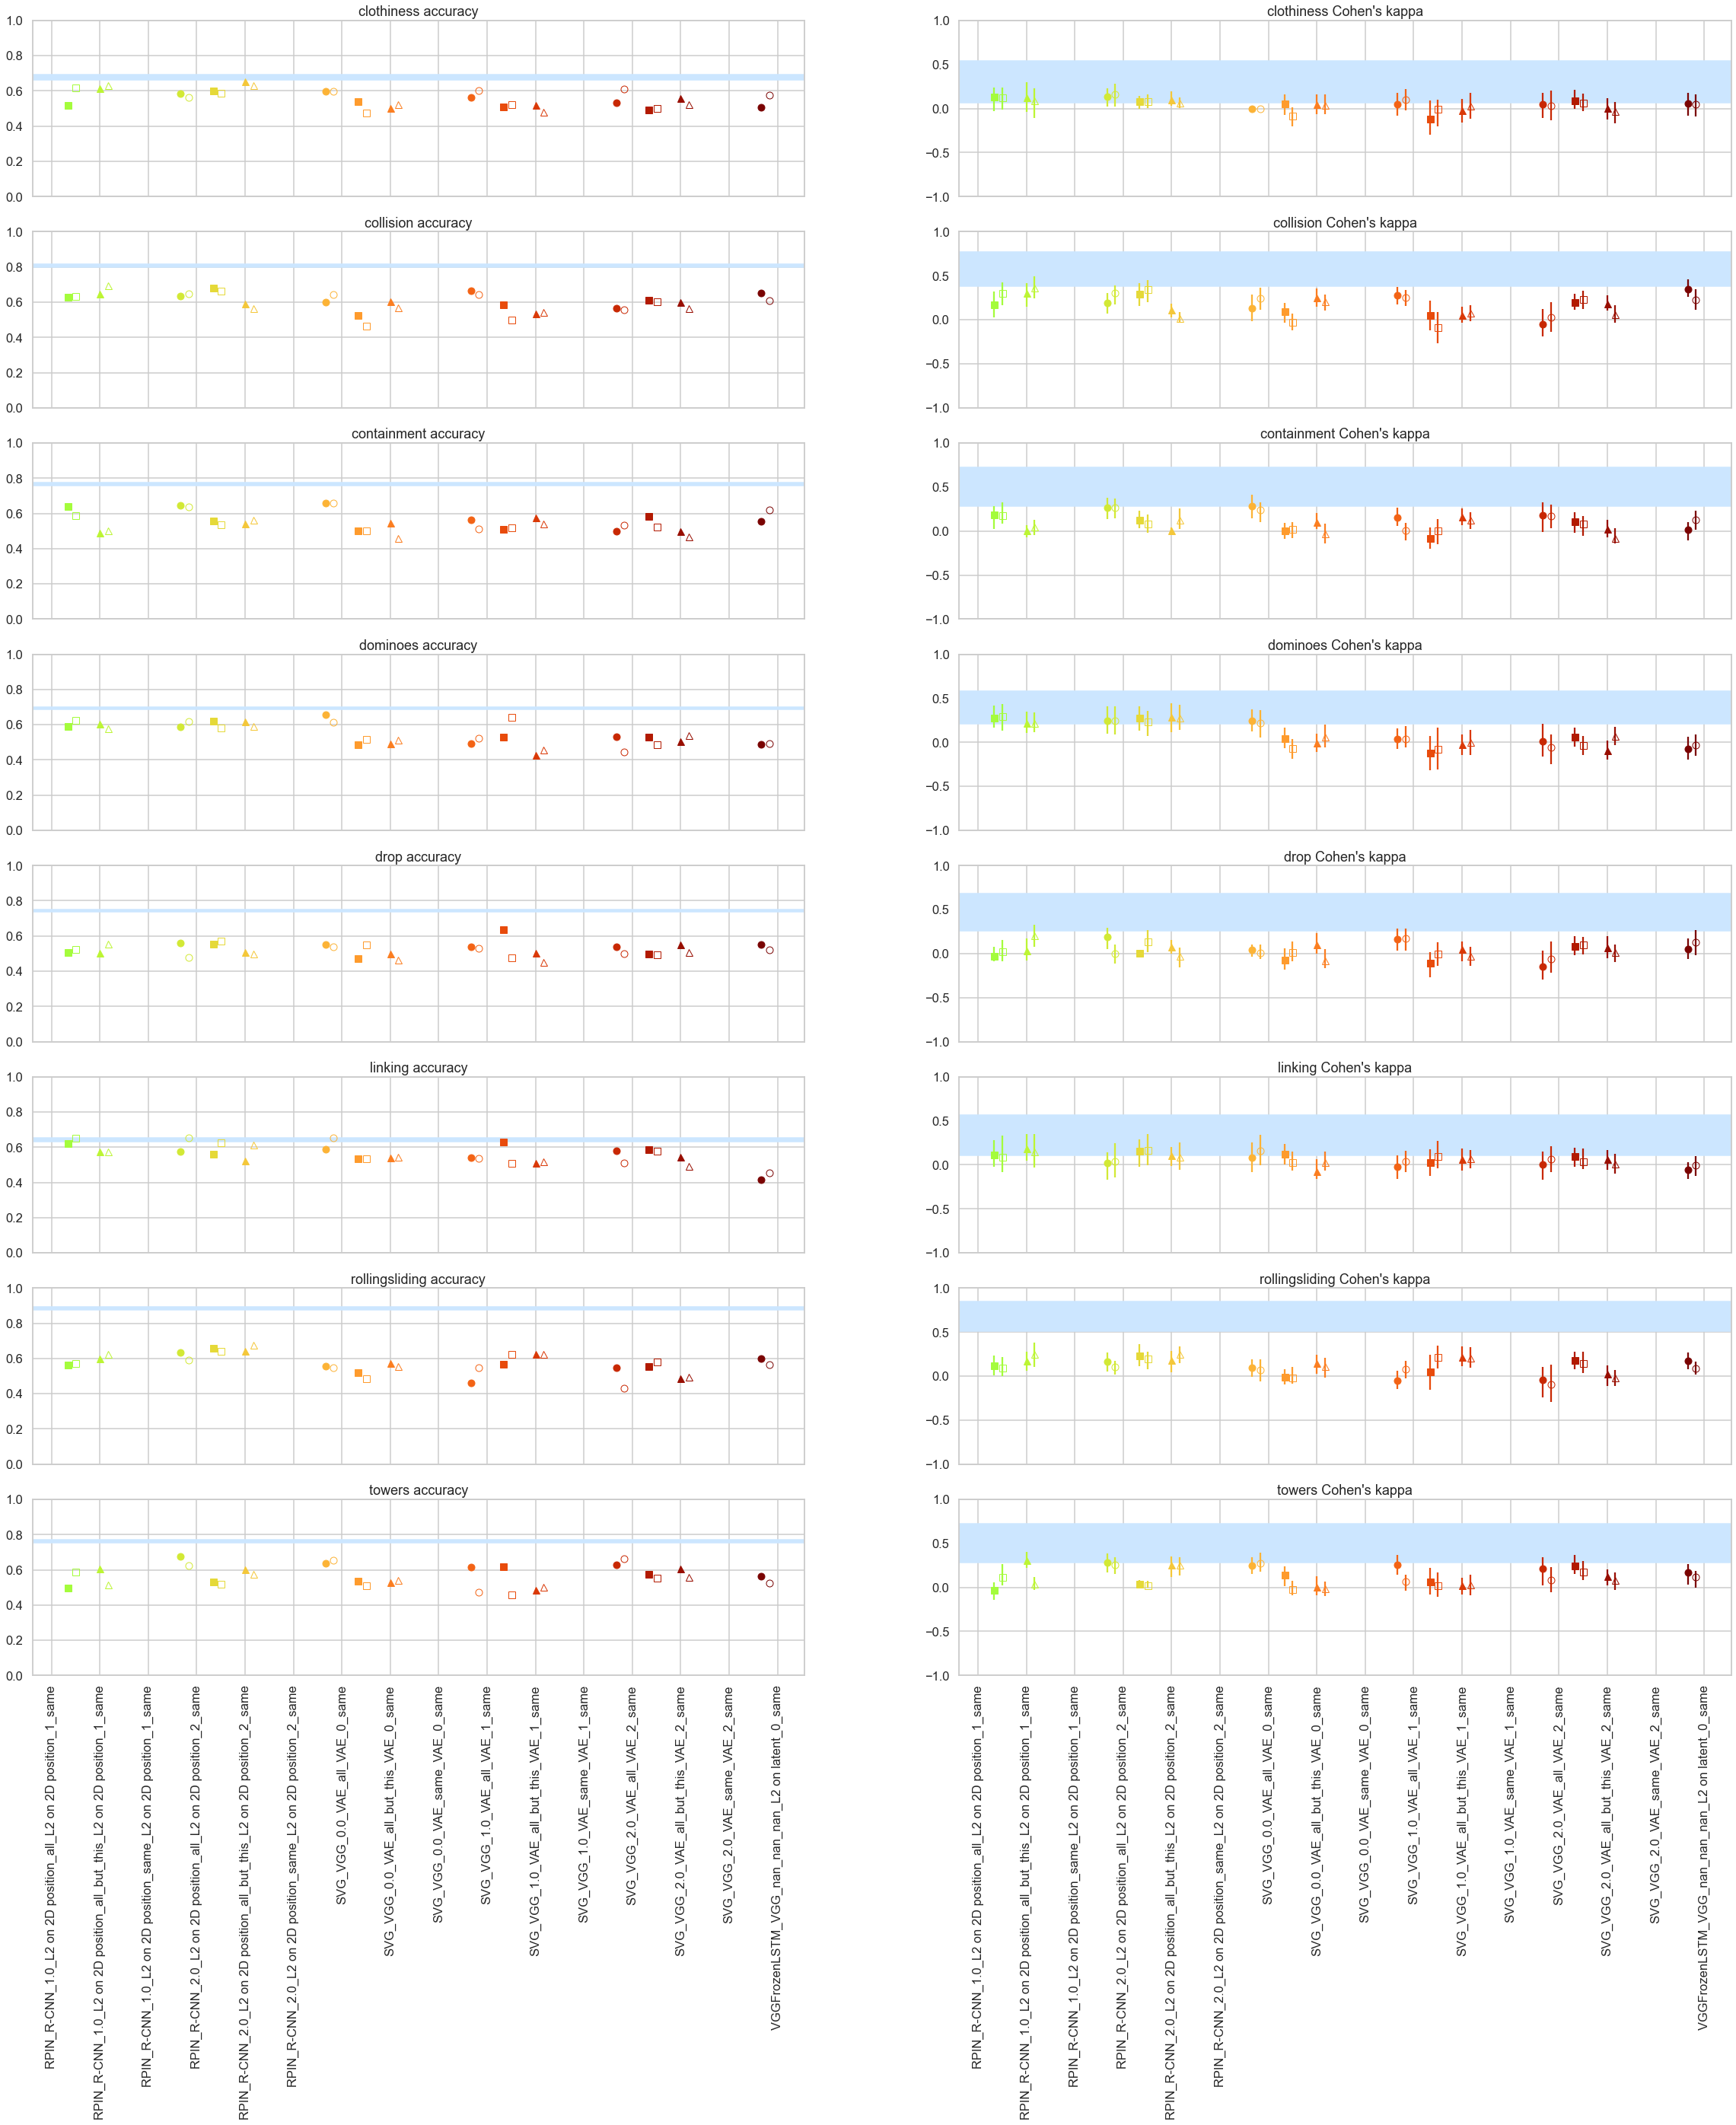

In [53]:
fig, axes = plt.subplots(len(MD['Readout Test Data'].unique()),2, figsize=(40,40), sharex=True, sharey=False)

models = sorted(MD['Model Kind'].unique())

for outer_y, scenario in enumerate(sorted(MD['Readout Test Data'].unique())):
    # ———accuracy plot———
    axis = axes[outer_y,0]
    axis.set_title(scenario + " accuracy")
    #plot human zone
    human_row = human_bootstrapped_accuracy[human_bootstrapped_accuracy['scenario'] == scenario]
    lb = float(human_row['ci_lb'])
    ub = float(human_row['ci_ub'])
    mean = float(human_row['obs_mean'])
    axis.axhspan(lb,ub,color=(.8,.9,1))
    axis.set_xticks(np.arange(len(models)))
    axis.set_xticklabels(models,rotation=90)
    
    # plot models
    for x,model in enumerate(models):
        #get relevant rows
        rows = model_human_accuracies[(model_human_accuracies['Model Kind'] == model) & (model_human_accuracies['scenario'] == scenario)]
        for readout,fill in READOUTS:
            for i,(training,symbol) in enumerate(TRAININGS):
                row = rows[(rows['Readout Type']==readout) & (rows['Dynamics Training Dataset Type'] == training)]
                if len(row) >1:
                    print((model, scenario, readout, training))
                if len(row) > 0: #do we have something to plot?
                    assert len(row) == 1, "More than one entry for specific agent"
                    lb = row['model_correct']
                    ub = row['model_correct']
                    measure = row['model_correct']
                    ub = abs(ub - measure)
                    lb = abs(lb - measure)
                    axis.errorbar(x+(i*.333)+(fill=="none")*.166,measure,(lb,ub),marker=symbol,fillstyle=fill,label=model,color=cmap[x])
        axis.set_ybound([0,1])
    
#     # ———correlation plot———
#     axis = axes[outer_y,1]
#     axis.set_title(scenario + " correlation")
#     #plot human zone
#     human_row = human_boot_corr[human_boot_corr['scenario'] == scenario]
#     lb = float(human_row['corr_lb'])
#     ub = float(human_row['corr_ub'])
#     mean = float(human_row['corr_med'])
#     axis.axhspan(lb,ub,color=(.8,.9,1))
#     axis.set_xticks(np.arange(len(models)))
#     axis.set_xticklabels(models,rotation=90)

#     # plot models
#     for x,model in enumerate(models):
#         #get relevant rows
#         rows = model_human_rmse[(model_human_rmse['Model Kind'] == model) & (model_human_rmse['scenario'] == scenario)]
#         for readout,fill in READOUTS:
#             for i,(training,symbol) in enumerate(TRAININGS):
#                 row = rows[(rows['Readout Type']==readout) & (rows['Dynamics Training Dataset Type'] == training)]
#                 if len(row) > 0: #do we have something to plot?
#                     assert len(row) == 1, "More than one entry for specific agent"
#                     lb = row['corr_lb']
#                     ub = row['corr_ub']
#                     measure = row['corr_med']
#                     ub = abs(ub - measure)
#                     lb = abs(lb - measure)
#                     axis.errorbar(x+(i*.333)+(fill=="none")*.166,measure,(lb,ub),marker=symbol,fillstyle=fill,label=model,color=cmap[x])
#         axis.set_ybound([0,1])
        
    
    # ———Cohens'k plot———
    axis = axes[outer_y,1]
    axis.set_title(scenario + " Cohen's kappa")
    #plot human zone
    human_row = human_boot_cohenk[human_boot_cohenk['scenario'] == scenario]
    lb = float(human_row['corr_lb'])
    ub = float(human_row['corr_ub'])
    mean = float(human_row['corr_med'])
    axis.axhspan(lb,ub,color=(.8,.9,1))
    axis.set_xticks(np.arange(len(models)))
    axis.set_xticklabels(models,rotation=90)

    # plot models
    for x,model in enumerate(models):
        #get relevant rows
        rows = model_human_CohensK[(model_human_CohensK['Model Kind'] == model) & (model_human_CohensK['scenario'] == scenario)]
        for readout,fill in READOUTS:
            for i,(training,symbol) in enumerate(TRAININGS):
                row = rows[(rows['Readout Type']==readout) & (rows['Dynamics Training Dataset Type'] == training)]
                if len(row) > 0: #do we have something to plot?
                    assert len(row) == 1, "More than one entry for specific agent"
                    lb = row['Cohens_k_lb']
                    ub = row['Cohens_k_ub']
                    measure = row['Cohens_k_med']
                    ub = abs(ub - measure)
                    lb = abs(lb - measure)
                    axis.errorbar(x+(i*.333)+(fill=="none")*.166,measure,(lb,ub),marker=symbol,fillstyle=fill,color=cmap[x])
        axis.set_ybound([-1,1])